### Import Necessary Libraries

In [1]:
import yfinance as yf
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Tesla has the ticker “tsla”.

In [2]:
ticker= "tsla"
tsla_data = yf.download(ticker, start="2018-01-01", end="2022-10-14")
tsla_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000


In [3]:
tsla_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-07,233.940002,234.570007,222.020004,223.070007,223.070007,83916800
2022-10-10,223.929993,226.990005,218.360001,222.960007,222.960007,67925000
2022-10-11,220.949997,225.750000,215.000000,216.500000,216.500000,77013200
2022-10-12,215.330002,219.300003,211.509995,217.240005,217.240005,66860700
2022-10-13,208.300003,222.990005,206.220001,221.720001,221.720001,91483000


### Calculate and plot the daily returns
Stock daily returns indicate the gain or loss per day for a given stock. We get it by subtracting the opening price from the closing price.
To calculate the daily returns, we use the .pct_change method.

In [4]:
tsla_data['Return'] = 100 * (tsla_data['Close'].pct_change())

Text(0.5, 1.0, 'Daily Returns Over Time')

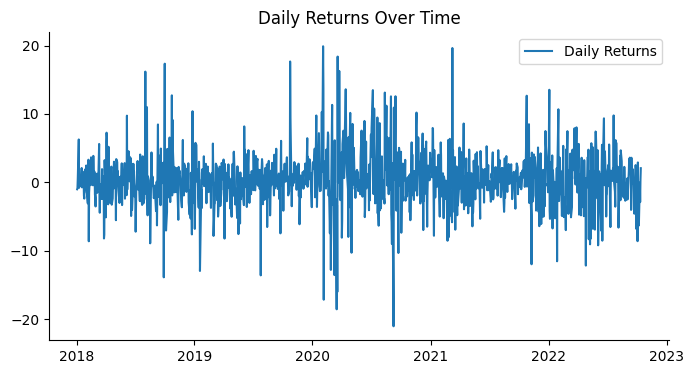

In [5]:
tsla_data.dropna(inplace=True)
fig,ax = plt.subplots(figsize=(8,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'], label = 'Daily Returns')
plt.legend(loc='upper right')
plt.title('Daily Returns Over Time')

### Calculate daily, monthly and annual volatility
A stock’s volatility is the variation in its price over a period of time.
Let’s calculate it with 3 durations: daily, monthly, annual.

**Daily volatility:** to get it, we calculate the standard deviation of the daily returns. As a reminder, the standard deviation helps us to see how much the data is spread around the mean or average.

**Monthly volatility:** we make the assumption that there are 21 trading days in the month so we multiply the daily volatility by the square root of 21.

**Annual volatility:** we assume there are 252 trading days in a calendar year, and we multiply the daily volatility by the square root of 252.

In [6]:
daily_volatility = tsla_data['Return'].std()

monthly_volatility = math.sqrt(21) * daily_volatility

annual_volatility = math.sqrt(252) * daily_volatility

from tabulate import tabulate

print(tabulate([['Tesla',daily_volatility,monthly_volatility,annual_volatility]],headers = ['Daily Volatility %',
                                                                                            'Monthly Volatility %',
                                                                                            'Annual Volatility %'],
               tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))

╒═══════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│       │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═══════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ Tesla │         4.11         │         18.83          │         65.22         │
╘═══════╧══════════════════════╧════════════════════════╧═══════════════════════╛


### Build GARCH model
GARCH is a method for estimating volatility in financial markets.
There are various types of GARCH modeling. When attempting to predict the prices and rates of financial instruments, financial professionals frequently prefer the GARCH process over other models.


In [7]:
!pip install arch

In [8]:
import arch
from arch import arch_model
from arch.__future__ import reindexing
garch_model = arch_model(tsla_data['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'normal')
gm_result = garch_model.fit(disp='off')
print(gm_result.params)
print('\n')
gm_forecast = gm_result.forecast(horizon = 5)
print(gm_forecast.variance[-1:])

mu          0.252721
omega       0.902331
alpha[1]    0.071748
beta[1]     0.873923
Name: params, dtype: float64


                  h.1        h.2        h.3        h.4        h.5
Date                                                             
2022-10-13  14.218493  14.348346  14.471145  14.587273  14.697091


### First analysis
The alpha of a stock indicates how well (or poorly) it has performed in comparison to a benchmark index.
Beta indicates how volatile a stock’s price has been in comparison to the market as a whole.

**alpha:** the bigger it is, the stronger the immediate volatility impact is.

**beta:** the bigger it is, the longer the volatility impact is.

**Line 12–13:** we use here the. forecast method to make a 5-period ahead forecast (horizon=5) and print the output in the variance.

### Rolling Predictions
At this point, we have developed a GARCH model that can forecast stock volatility. We can now put our model to the test using historical data from the n-period of time in a rolling prediction process.

Text(0.5, 1.0, 'Rolling Prediction')

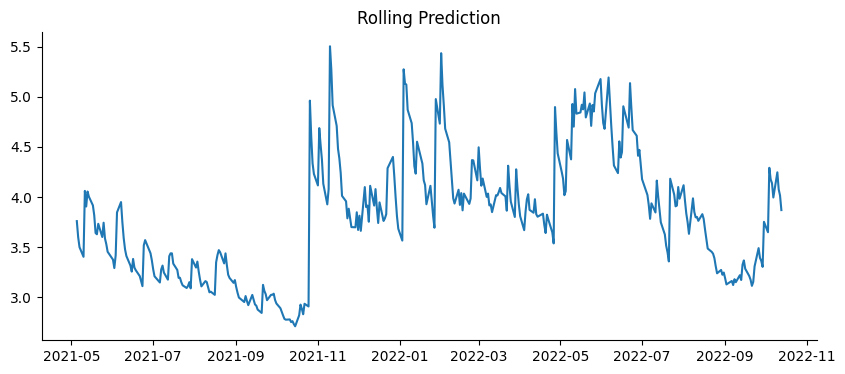

In [11]:
rolling_predictions = []
test_size = 365

for i in range(test_size):
    train = tsla_data['Return'][:-(test_size-i)]
    model = arch_model(train, p=1, q=1)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

rolling_predictions = pd.Series(rolling_predictions, index=tsla_data['Return'].index[-365:])

fig,ax = plt.subplots(figsize=(10,4))
ax.spines[['top','right']].set_visible(False)
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')

In this section, we create a training set in a loop using the stock daily return values from the first to the -(test size-i) day.
In each loop, the current training set is used to train a GARCH model with the parameters p and q set to 1. The current model forecasts volatility with a 1-time step (horizon=1) and then squares the predicted volatility variance. The result (standard deviation) is appended to the rolling predictions.

### Accuracy of GARCH Model
To review this, we will create another subplot of daily returns (true values) and overlay it with the rolling prediction line plot.

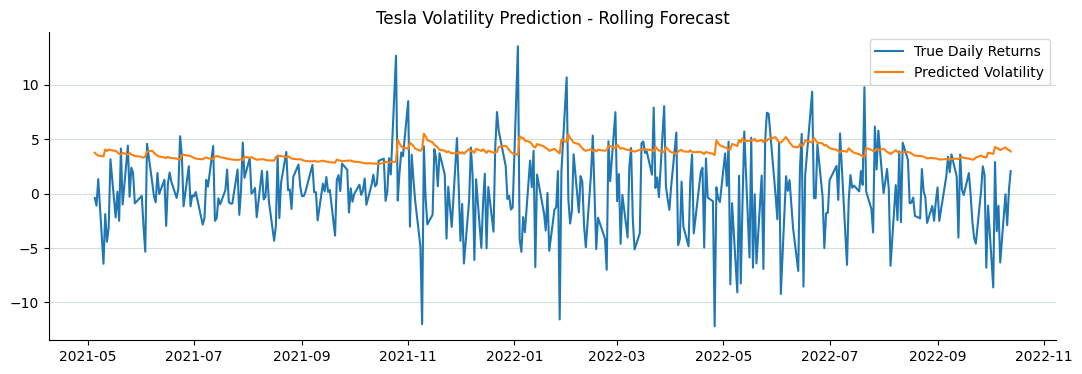

In [13]:
fig,ax = plt.subplots(figsize=(13,4))
ax.grid(which="major", axis='y', color='#758D99', alpha=0.3, zorder=1)
ax.spines[['top','right']].set_visible(False)
plt.plot(tsla_data['Return'][-365:])
plt.plot(rolling_predictions)
plt.title('Tesla Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])

We can see from the subplots above that our predicted volatility is generally in line with the daily returns.
This means that our GARCH model works well in this situation. Daily returns are high in areas where volatility is expected to be high.